In [1]:
import arcpy
import os
import pandas as pd
import numpy as np
from arcpy import env
from arcpy.management import *
from arcpy.conversion import *
from arcpy.da import *
from arcpy.sa import *

# 矢量计算实现

In [ ]:
# 获取要素字段
def get_filed(ele_path):
    """获取输入要素的字段及类型"""
    field_dict = {}
    for one_field in arcpy.ListFields(ele_path):
        field_dict[one_field.name] = one_field.type
    return field_dict
# 获取要素的df表
def get_ele_df(ele_path,field_list):
    """获取输入要素的df表"""
    df = pd.DataFrame(TableToNumPyArray(ele_path,field_list))
    return df


# 按属性选择并导出为要素类
def export_ele_by_attr(in_path, out_path, field_name, field_values):
    """
    按属性选择并导出为要素类，field_values可以是单个值也可以是一个列表

    参数:
    in_path: 输入要素类的路径
    out_path: 输出要素类的路径
    field_name: 用于选择的字段名称
    field_values: 单个字段值或字段值列表，基于这些值进行选择
    """
    # 确保field_values总是列表
    if not isinstance(field_values, list):
        field_values = [field_values]  # 将单个值转换为列表

    # 将输入的要素类转换为图层
    temp_layer = "tempLayer"
    arcpy.MakeFeatureLayer_management(in_path, temp_layer)
    
    # 清除在临时图层上的任何现有选择
    arcpy.SelectLayerByAttribute_management(temp_layer, "CLEAR_SELECTION")
    
    # 构建查询语句以处理值列表
    values_str = ','.join([f"'{value}'" for value in field_values])
    query = f"{field_name} IN ({values_str})"
    
    # 使用查询语句按属性选择
    arcpy.SelectLayerByAttribute_management(temp_layer, "NEW_SELECTION", query)
    
    # 检查是否有选择的要素
    if int(arcpy.GetCount_management(temp_layer)[0]) > 0:
        # 导出选择的要素
        arcpy.CopyFeatures_management(temp_layer, out_path)
        print(f"已成功导出要素到 {out_path}")
    else:
        print("没有找到匹配的要素。")
    
    # 清理临时图层
    arcpy.Delete_management(temp_layer)




In [ ]:
work_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_dy'
env.workspace = work_path
env.overwriteOutput = True

In [ ]:
arcpy.ListFeatureClasses()

In [ ]:
gtsd_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_dy\dy_sd'
temp_path = r'D:\ArcGISProjects\workspace\shbyq\soil_type_result.gdb\soiltype_dy\soiltype_prediction_CATB_20240226'

In [ ]:
field_dict = get_filed(gtsd_path)

In [ ]:
field_dict

In [ ]:
df = get_ele_df(gtsd_path,['DLBM','DLMC'])
# 去重
df =df.drop_duplicates()
df

In [ ]:
df = get_ele_df(temp_path,['TL'])
# 去重
df =df.drop_duplicates()
df

In [ ]:
export_ele_by_attr(temp_path,'dy_pre_tl','TL','水稻土')

In [ ]:
export_ele_by_attr('dy_sd','dy_ZRT','DLMC',['茶园','其他园地','乔木林地','竹林地','灌木林地','其他林地','人工牧草地','其他草地'])

# 栅格计算实现

In [2]:
import numpy as np
import arcpy
from scipy.spatial import cKDTree

In [3]:
def load_raster_as_array(raster_path):
    """
    将栅格数据加载为NumPy数组。
    """
    return arcpy.RasterToNumPyArray(raster_path)

def create_cKDTree_for_replacement(raster, mask, inverse=False):
    """
    根据指定的掩码创建cKDTree，用于快速寻找最近的替代值。
    inverse参数决定是使用掩码(True)还是反掩码(False)中的位置创建树。
    """
    if inverse:
        positions = np.column_stack(np.where(~mask))
    else:
        positions = np.column_stack(np.where(mask))
    return cKDTree(positions), positions
def find_and_replace_with_mapping(pre_raster, dl_raster, mapping, paddy_codes):
    """
    根据dl_raster到pre_raster的映射关系，查找并替换需要调整的像素值。
    """
    corrected_raster = np.copy(pre_raster)
    for dl_code, target_pre_codes in mapping.items():
        # 找到dl_raster中指定dl_code的所有位置
        dl_mask = dl_raster == dl_code
        # 找出这些位置中pre_raster不在目标水田代码列表中的像素
        replace_mask = dl_mask & (~np.isin(pre_raster, target_pre_codes))
        # 对这些需要替换的像素进行处理
        corrected_raster = find_and_replace_nearest(corrected_raster, replace_mask, paddy_codes)
    
    return corrected_raster


def find_and_replace_nearest(target_raster, mask, replacement_codes, inverse=False):
    """
    查找并替换栅格中需要被替代的值。
    """
    corrected_raster = np.copy(target_raster)
    tree, valid_positions = create_cKDTree_for_replacement(target_raster, np.isin(target_raster, replacement_codes), inverse)
    to_be_replaced = np.column_stack(np.where(mask))
    
    if to_be_replaced.size > 0:
        _, nearest_indices = tree.query(to_be_replaced)
        nearest_valid_values = target_raster[valid_positions[nearest_indices][:, 0], valid_positions[nearest_indices][:, 1]]
        corrected_raster[to_be_replaced[:, 0], to_be_replaced[:, 1]] = nearest_valid_values

    return corrected_raster

In [4]:
env.workspace = r'D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_dy.gdb'

In [5]:
# 示例使用
pre_raster_path = r'D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_dy.gdb\prediction_soiltype_RFE_20240418'
dl_raster_path = r'D:\ArcGISProjects\workspace\shbyq\feature_raster_file\features_data_dy.gdb\DL'
output_raster_path = "prediction_soiltype_RFE_20240418_reclass"

In [6]:
df_table = pd.read_csv(r"C:\Users\Runker\Desktop\dy_0417.csv")

In [22]:
# # 对每个唯一的土种编号生成一个字典
# def aggregate_rows(group):
#     records = group[['TZ', 'YL', 'TS']].to_dict('records')
#     # 假设每个土种编号下的记录是相同的，这里我们取第一个记录
#     return records if records else {}

# # 使用groupby按照`土种编号`聚合，并应用自定义函数
# soil_dict = df_table.groupby('TL').apply(aggregate_rows).to_dict()
soil_dict = df_table.groupby('TL')['TZ'].apply(set).to_dict()

In [24]:
sdt_tz = soil_dict['水稻土']
sdt_tz

{'中白鳝泥田',
 '冷水田',
 '冷沙田',
 '冷浸田',
 '大泥田',
 '大眼泥田',
 '大眼黄泥田',
 '小黄泥田',
 '干鸭屎泥田',
 '扁沙泥田',
 '死黄泥田',
 '浅足烂泥田',
 '深足烂泥田',
 '湿鸭屎泥田',
 '潮板沙田',
 '潮沙泥田',
 '潮沙田',
 '潮油沙泥田',
 '潮泥田',
 '烂锈田',
 '熟鸭屎泥田',
 '白沙泥田',
 '苦大泥田',
 '重白胶泥田',
 '重白鳝泥田',
 '铅毒田',
 '锈水田',
 '雾黄泥田',
 '马血泥田',
 '黄大泥田',
 '黄沙泥田',
 '黄油沙泥田',
 '黄泥田',
 '黄石砂田',
 '黄胶泥田',
 '黑潮泥田',
 '龙凤大眼泥田'}

In [10]:
temp_dict = {0: ['中白鳝泥田'], 1: ['中腐殖层中土层硅质黄壤'], 2: ['中腐殖层中土层黄色石灰土'], 3: ['中腐殖层厚土层硅质黄壤'], 4: ['中腐殖层薄土层硅质黄壤'], 5: ['中腐殖层薄土层黄色石灰土'], 6: ['偏沙土'], 7: ['冷水田'], 8: ['冷沙土'], 9: ['冷沙田'], 10: ['冷浸田'], 11: ['大泥土'], 12: ['大泥田'], 13: ['大眼泥田'], 14: ['大眼黄泥田'], 15: ['小泥土'], 16: ['小黄泥土'], 17: ['小黄泥田'], 18: ['岩泥'], 19: ['干鸭屎泥田'], 20: ['扁沙泥田'], 21: ['死黄泥土'], 22: ['死黄泥田'], 23: ['浅足烂泥田'], 24: ['深足烂泥田'], 25: ['湿鸭屎泥田'], 26: ['潮板沙田'], 27: ['潮沙泥田'], 28: ['潮沙田'], 29: ['潮油沙泥田'], 30: ['潮泥田'], 31: ['火石沙土'], 32: ['烂锈田'], 33: ['熟鸭屎泥田'], 34: ['白云沙土'], 35: ['白沙土'], 36: ['白沙泥田'], 37: ['石碴子土'], 38: ['砾质紫沙土'], 39: ['紫沙土'], 40: ['紫色土'], 41: ['苦大泥田'], 42: ['薄腐殖中土层山地灌丛草甸土'], 43: ['薄腐殖层中土层山地灌丛草甸土'], 44: ['薄腐殖层中土层次生黄色石灰土'], 45: ['薄腐殖层中土层硅质黄壤'], 46: ['薄腐殖层中土层硅铁质黄壤'], 47: ['薄腐殖层中土层硅铝质黄壤'], 48: ['薄腐殖层中土层紫色土'], 49: ['薄腐殖层中土层铁铝质黄壤'], 50: ['薄腐殖层中土层黄色石灰土'], 51: ['薄腐殖层中土层黑色石灰土'], 52: ['薄腐殖层厚土层山地灌丛草甸土'], 53: ['薄腐殖层厚土层次生黄色石灰土'], 54: ['薄腐殖层厚土层硅质黄壤'], 55: ['薄腐殖层厚土层硅铁质黄壤'], 56: ['薄腐殖层厚土层硅铝质黄壤'], 57: ['薄腐殖层厚土层铁铝质黄壤'], 58: ['薄腐殖层厚土层黄色石灰土'], 59: ['薄腐殖层厚土层黑色石灰土'], 60: ['薄腐殖层薄土层山地灌丛草甸土'], 61: ['薄腐殖层薄土层次生黄色石灰土'], 62: ['薄腐殖层薄土层淋溶黄色石灰土'], 63: ['薄腐殖层薄土层硅质黄壤'], 64: ['薄腐殖层薄土层硅铁质黄壤'], 65: ['薄腐殖层薄土层硅铝质黄壤'], 66: ['薄腐殖层薄土层紫色土'], 67: ['薄腐殖层薄土层酸性紫色土'], 68: ['薄腐殖层薄土层铁质黄壤'], 69: ['薄腐殖层薄土层铁铝质黄壤'], 70: ['薄腐殖层薄土层黄壤性土'], 71: ['薄腐殖层薄土层黄色石灰土'], 72: ['薄腐殖层薄土层黑色石灰土'], 73: ['薄腐殖薄土层山地灌丛草甸土'], 74: ['重白胶泥田'], 75: ['重白鳝泥田'], 76: ['钙石子土'], 77: ['铅毒田'], 78: ['锈水田'], 79: ['雾黄泥田'], 80: ['马血泥田'], 81: ['黄大泥田'], 82: ['黄沙泥土'], 83: ['黄沙泥田'], 84: ['黄油沙泥田'], 85: ['黄泥土'], 86: ['黄泥田'], 87: ['黄石砂田'], 88: ['黄胶泥土'], 89: ['黄胶泥田'], 90: ['黑潮泥田'], 91: ['龙凤大眼泥田']}

In [27]:
sdt_code  = [key for key,value in temp_dict.items() if value[0] in sdt_tz]

In [29]:
print(sdt_code)

[0, 7, 9, 10, 12, 13, 14, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 36, 41, 74, 75, 77, 78, 79, 80, 81, 83, 84, 86, 87, 89, 90, 91]


In [30]:
# 定义类别代码
paddy_codes = [0, 7, 9, 10, 12, 13, 14, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 36, 41, 74, 75, 77, 78, 79, 80, 81, 83, 84, 86, 87, 89, 90, 91] # 水稻土代码
natural_soil_codes_dl = [4,5,6,7,8,9,10,11,12,20,35,36]  # dl_raster中自然土代码

# 条件1: dl_raster中标记为水田的像素在pre_raster中也必须是水田代码
# 映射字典
mapping = {
    1: paddy_codes,  # dl_raster中的1对应pre_raster中的所有水田代码
    2: paddy_codes,  # 同上
    30: paddy_codes,   # 同上
    31: paddy_codes,   # 同上
    32: paddy_codes,   # 同上
    39: paddy_codes   # 同上
}

In [31]:
pre_raster = load_raster_as_array(pre_raster_path)
dl_raster= load_raster_as_array(dl_raster_path)

In [32]:
pre_raster.shape, dl_raster.shape

((12881, 13343), (12881, 13343))

In [33]:
# 使用映射字典处理条件1
corrected_raster_condition1 = find_and_replace_with_mapping(pre_raster, dl_raster, mapping, paddy_codes)

# 处理条件2: pre_raster中为水田代码的像素，对应的dl_raster的值不应该在自然土代码列表中
natural_soil_mask_dl = np.isin(dl_raster, natural_soil_codes_dl)  # dl_raster中自然土的掩码
paddy_in_pre = np.isin(pre_raster, paddy_codes)  # pre_raster中水田的掩码
condition2_mask = natural_soil_mask_dl & paddy_in_pre
corrected_raster_condition2 = find_and_replace_nearest(corrected_raster_condition1, condition2_mask, paddy_codes, True)


In [34]:
env.extent = pre_raster_path

In [35]:
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster

In [36]:
result_raster = mask_raster(corrected_raster_condition2,pre_raster_path, 5)

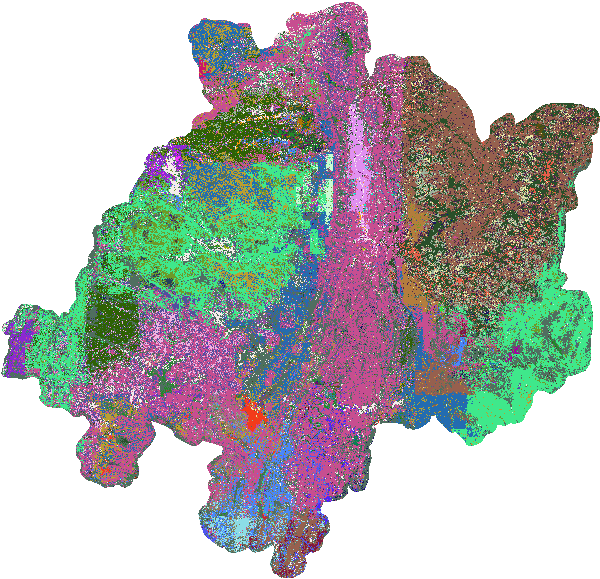

In [37]:
arcpy.sa.Int(result_raster)

In [38]:
result_raster.save(output_raster_path)